#### Funtions to upsample and 'sinc' interpolate

In [1]:

# based on example from matlab sinc function and
# interpolate.m by H. Hobæk (1994).
#
# this implementation is similar to the matlab sinc-example, but
# calculates the values sequentially and not as a single matrix
# matrix operation for all the values.
#

import scipy as sc
import numpy as np


def upsample (x, k):
  """
  Upsample the signal to the given ratio using a sinc kernel
  input:
    x   a vector or matrix with a signal in each row
    k   ratio to resample to
    returns
    y   the up or downsampled signal
    when downsampling the signal will be decimated using scipy.signal.decimate
  """

  assert k >= 1, 'k must be equal or greater than 1'

  mn = x.shape
  if len(mn) == 2:
    m = mn[0]
    n = mn[1]
  elif len(mn) == 1:
    m = 1
    n = mn[0]
  else:
    raise ValueError ("x is greater than 2D")

  nn = n * k

  xt = np.linspace (1, n, n)
  xp = np.linspace (1, n, nn)

  return interp (xp, xt, x)


def interp (xp, xt, x):
  """
  Interpolate the signal to the new points using a sinc kernel
  input:
  xt    time points x is defined on
  x     input signal column vector or matrix, with a signal in each row
  xp    points to evaluate the new signal on
  output:
  y     the interpolated signal at points xp
  """

  mn = x.shape
  if len(mn) == 2:
    m = mn[0]
    n = mn[1]
  elif len(mn) == 1:
    m = 1
    n = mn[0]
  else:
    raise ValueError ("x is greater than 2D")

  nn = len(xp)

  y = np.zeros((m, nn))

  for (pi, p) in enumerate (xp):
    si = np.tile(np.sinc (xt - p), (m, 1))
    y[:, pi] = np.sum(si * x)

  return y.squeeze ()


#### DSSS binary code sequence - upsampling and interpolation
<ul>
<li> Refer to my <b>medium post</b> on how I managed to find the DSSS code-sequence used here. 
<li> The Github repo also contains a GLFSR implementation that you could use for other similar such experiments.
</ul>

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.pyplot import step, xlim, ylim, show
from scipy import signal

a = np.array([-1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, 1, 1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1])

# code-sequence
b = np.tile(a, 1)
x = np.arange(0, 127)

# code-signal
us1 = upsample(b, 16) 

fig, (ax1, ax2) = plt.subplots(2, figsize=(15,10))
ax1.step(x, b)
ax1.set_title('DSSS Binary Code Sequence', fontsize=12, fontweight="bold")
ax2.plot(us1, 'tab:green')
ax2.set_title('Sinc Interpolated DSSS Code Signal', fontsize=12, fontweight="bold")

Text(0.5, 1.0, 'Sinc Interpolated DSSS Code Signal')

#### Load a 'translated and low-pass filtered' copy of the signal
<ul>
    <li> Refer to the <b>GNU-Radio flowgraph</b> for more on signal translation and filtering.
<li> Center frequency is translated by 16.5khz</li>
<li>The cut-off bandwidth for the low pass filter is 1.5khz</li>
</ul>

(426560, 2)
426560


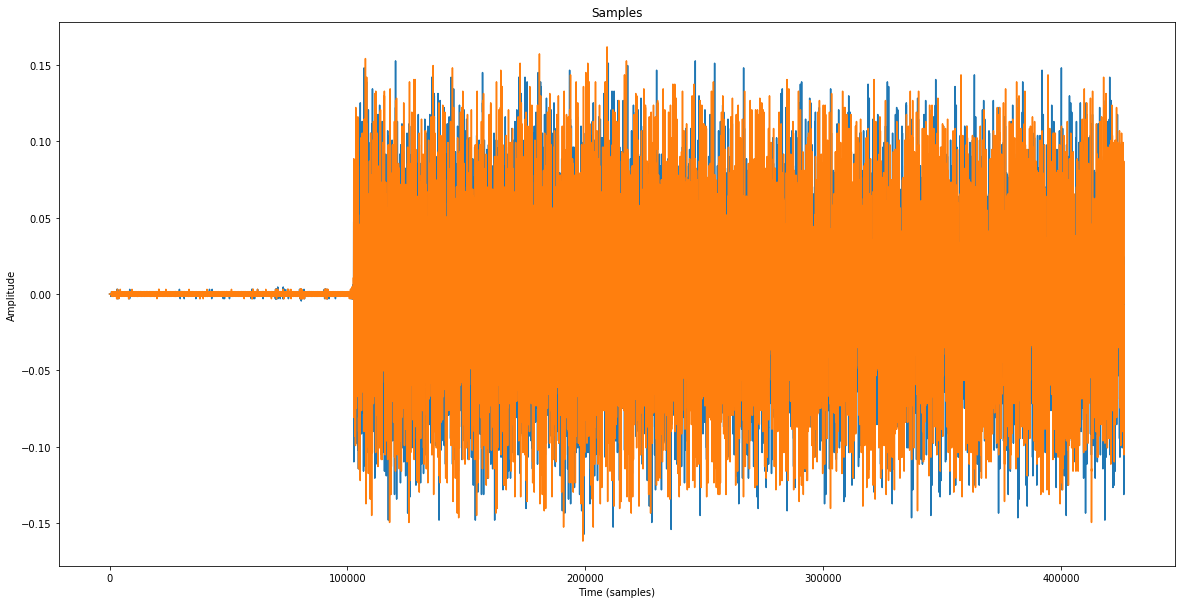

In [24]:
import numpy as np
import os
from scipy.io import wavfile

file_path = "/Users/Nil/devspace/Github_repos/alltheFSKs/iPhone_MFSK_Gpay_samples/iPhone_stereo_r_48khz_04022020_c3444867_translated_lpf.wav"

fs, data = wavfile.read(file_path)

# print(fs)

if(data.dtype == np.int16):
   data = data.astype(np.float)/2**16

number_of_complex_samples = len(data)
print(data.shape)
print(len(data))

re, im = np.hsplit(data, 2)

re = np.multiply(re.reshape(data.shape[0],), 1e+02)
im = np.multiply(im.reshape(data.shape[0],), 1e+02)

plt.figure(figsize=(20,10))
plt.plot((re))
plt.plot(im)
plt.ylabel("Amplitude")
plt.xlabel("Time (samples)")
plt.title("Samples")
plt.show()



#### Synchronization via cross-correlation of interpolated code-signal with filtered baseband
<ul>
<li>Correlation is a simple multiply and accumulate operation</li>
<li>In this case, we're sliding our code-signal forward by 1 sample and correlating it against the received (and filtered) baseband </li>
<li>Loosely speaking, we're looking for the code-signal in our received baseband. At some point our code-signal aligns with the received signal and at that point we get a nice spike. (See plot below) </li>
<li> Note - Samples between correlation peaks are our symbols. You'll see why as we move forward. 
</ul>

2032
422656
89.50084370678948
422656
8010.401024227159


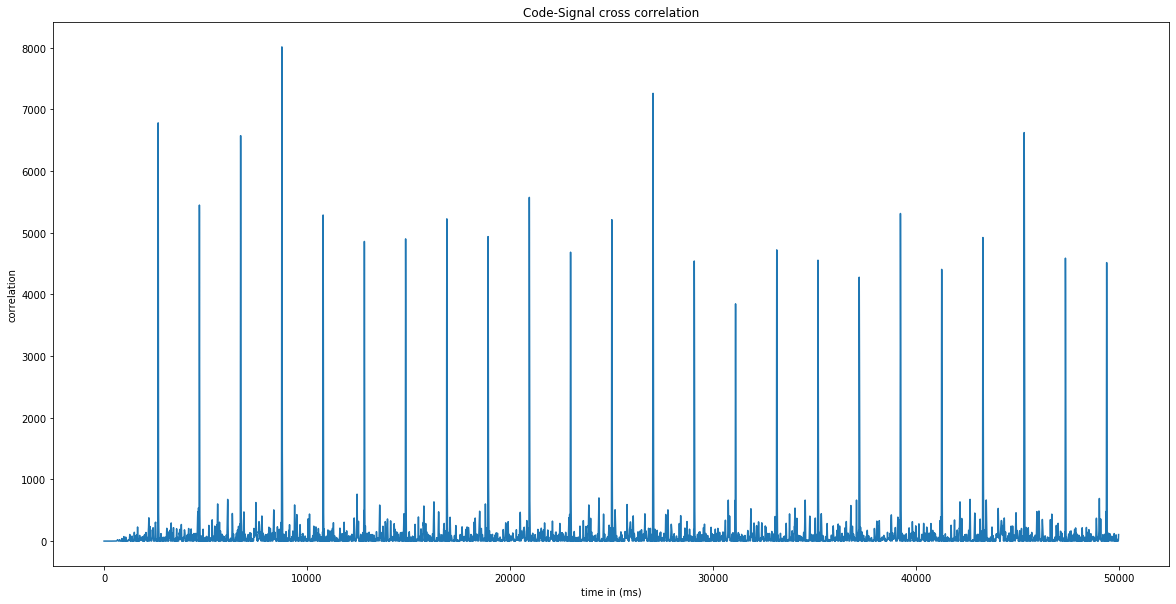

In [25]:

number_of_code_samples = len(us1)
print(len(us1))

correlation_magnitude_buffer = []
normalized_correlation_magnitude_buffer = []

# so that we dont overshoot when sliding the code signal forward
range_ = (int(number_of_complex_samples/number_of_code_samples)-1)*number_of_code_samples

for i in range(0, int(range_)):
    real_correl = np.correlate(us1, re[ i  : i + len(us1) ])[0]
    imag_correl = np.correlate(us1, im[ i  : i + len(us1) ])[0]

    correlation_magnitude = real_correl + imag_correl
    normalized_correl_magnitude = correlation_magnitude**2

    correlation_magnitude_buffer.append(correlation_magnitude)
    normalized_correlation_magnitude_buffer.append(normalized_correl_magnitude)
    
print(len(correlation_magnitude_buffer))
print(max(correlation_magnitude_buffer))
print(len(normalized_correlation_magnitude_buffer))
print(max(normalized_correlation_magnitude_buffer))

plt.figure(figsize=(20,10))
plt.plot((normalized_correlation_magnitude_buffer[100000:150000]))
plt.xlabel('time in (ms)')
plt.ylabel('correlation')
plt.title('Code-Signal cross correlation')
plt.show()

##### Find the first largest correlation peak. 
<ul>
<li>The first largest peak is at sample number 102667 with a correlation peak of 6778.869459286602
<li> Note -This still needs a human eye for now as correlation magnitude keeps changing with strength of received signal. So, you cant use a common threshold for 2 different audio recordings. Normalization might help but I have not thought of a way to automate this part yet. 
</ul>

In [29]:

h3 = sorted((v,i) for (v,i) in enumerate(normalized_correlation_magnitude_buffer) if (i > 6000) and ( v < 103000))
h4 = max([i for v,i in h3])

print(h3)
print(h4)

[(102663, 6005.358690015815), (102664, 6350.586618758092), (102665, 6600.014636510279), (102666, 6743.937839915293), (102667, 6778.869459286602), (102668, 6704.761345117046), (102669, 6527.362507124576), (102670, 6256.471331251961)]
6778.869459286602


#### DSSS code tracking 
<ul>
<li> If we were to just pick the next 2032 samples after our first highest peak
<li> You'd notice that after a few thousand samples, the code-signal is no longer aligned at the right correlation peak. 
<li> The reason - in a perfect world where interference or noise does not exist, we should just be able to take the next len(code_signal) samples and be on our way but sadly that world doesn't exist.
<li> So, we have to account for this by checking for the next highest peak at every probable alignment boundary. 
<li> In our case, we look for the highest peak in the next probable alignment boundary (+ and -200 samples) 
</ul>

In [30]:

i = 102667

peaks = []

while True:
    
    v = max(normalized_correlation_magnitude_buffer[i-200 : i+200])

    s, = np.where(np.isclose(normalized_correlation_magnitude_buffer, v, rtol = 1e-09)) 
    print('Index : {0}, Corr : {1}'.format(s, v))
    
    peaks.append([s[0],v])
    
    i = s[0] + 2032
            
    if i > data.shape[0]-2*2032:
        print('done')
        break


Index : [102667], Corr : 6778.869459286602
Index : [104699], Corr : 5446.378802750726
Index : [106731], Corr : 6571.969354420192
Index : [108764], Corr : 8010.401024227159
Index : [110796], Corr : 5285.6960930463565
Index : [112829], Corr : 4857.153234957815
Index : [114862], Corr : 4898.326299451809
Index : [116893], Corr : 5223.078269882726
Index : [118925], Corr : 4935.620500635903
Index : [120958], Corr : 5571.369020180033
Index : [122991], Corr : 4682.715513388305
Index : [125023], Corr : 5210.365945522694
Index : [127056], Corr : 7257.748610590412
Index : [129087], Corr : 4539.764305793891
Index : [131122], Corr : 3845.287572952842
Index : [133152], Corr : 4720.180969343814
Index : [135184], Corr : 4553.14830195491
Index : [137215], Corr : 4276.936784415769
Index : [139248], Corr : 5310.010049459368
Index : [141281], Corr : 4404.593242441256
Index : [143312], Corr : 4920.818472382275
Index : [145346], Corr : 6621.557248338889
Index : [147379], Corr : 4585.940462212541
Index : [14

#### Despreading the signal and visualising data via a Fourier transform 
<ul>
<li> Now that we have our correlated peaks. We can start despreading our signal.
<li> To de-spread the signal - multiply the code-signal (i.e. its 2032 samples) with a slice of the received signal i.e. <b>starting with a peak + the next 2032 samples</b> (we'll call this sequence <b>2032-peak samples or 1 symbol period</b> for short-hand)
<li> Despreading the signal reveals the actual MFSK signal (i.e. the real data signal) that we're interested in.
<li> The code snippet below plots an FFT (or in simpler terms a frequency domain plot) of a random slice of (i.e. one symbol) of the  recieved signal
<li> You do this a hundred times, you should be able to observe that pretty much all frequency plots have spikes in the 100 to 500 hz range. 
<li> This probably means the actual MFSK signal is probably in this range. 
</ul>

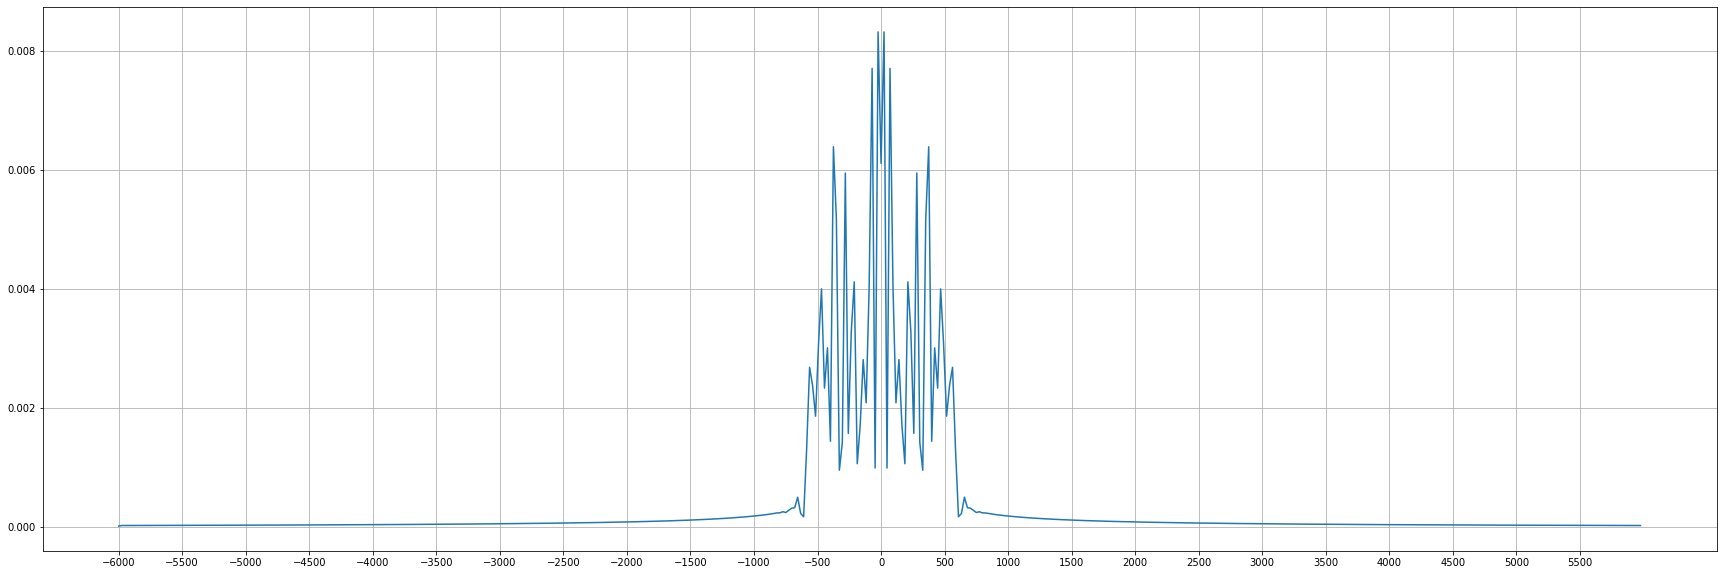

In [31]:

from scipy.fftpack import fft, fftfreq, fftshift
from scipy import signal
from scipy.signal import butter,filtfilt


k = 421682                               # one of the peaks chosen randomly 
sample_rate = 48000
nyq_rate = sample_rate / 2.0
order = 9
cutoff = 560

despread_re = np.multiply(us1, re[ k  : k + len(us1) ])
despread_im = np.multiply(us1, im[ k  : k + len(us1) ])

# Apply a low pass filter with the cut-off at 560 hz seems to work well.
normal_cutoff = cutoff / nyq_rate
# Get the filter coefficients 
b, a = butter(order, normal_cutoff, btype='low', analog=False)
y = filtfilt(b, a, despread_re)

f = signal.resample(y, 512)

N = 512
# sample spacing
T = 1.0 / 12000.0
yf = fft(f)
xf = fftfreq(N, T)
xf = fftshift(xf)
yplot = fftshift(yf)

plt.figure(figsize=(30,10))
plt.plot(xf, 1.0/N * np.abs(yplot))
plt.xticks(np.arange(min(xf), max(xf)+1, 500.0))
plt.grid()
plt.show()


#### Symbol Extraction 
<ul>
<li> MFSK is not very different from binary FSK. The difference is that -with MFSK you have more frequencies and each one is spaced at a fixed distance from the other - i.e. (symbol_rate) width  
<li> In our case, we have 16 frequencies/tones, each spaced 23.6 Hz from the next one. 23.6 is also the symbol rate (You can read more about how I arrived at this conclusion in my blog). 
<li> Now that we know pretty much everything you need to -about the MFSK signal. Lets get to MFSK demodulation 
<li> Here's the best part- we know that each set of 2032-peak samples is a symbol. In terms of real physics, you can think of a symbol as a single burst of a particular frequency and we have 16 different frequencies which represent 16 different symbols. 
<li> Given the above, if we were to perform a Fourier transform (frequency domain plot) for each of the 2032-peak samples (or symbols), it should (in theory) give us the tones that fired for each corresponding symbol period.  
<li> Put simply, we take an FFT of the real and imaginary components separately for each symbol and look for the frequency/tone with the highest energy content. That's our symbol. 
</ul>

In [32]:

symbols_real = []
symbols_imag = []

base_freq = 100                     # This is in Hertz
symbol_rate = 23.6
num_tones = 16                      # This particular MFSK modulation contains 16 tones i.e. (500-100/23.6) =~ 16.95  
                                    # But its apparently odd to have an odd number of frequencies
                                    # So, I settled on '16'. Turns out that was right. 
tone_zero = int(round(base_freq/symbol_rate))       # the first or lowest tone in the sequence 

sample_rate = 48000
nyq_rate = sample_rate / 2.0
order = 9                          # This number is after experimentation. like Filter-design always is
cutoff = 560                       # same as above.

for index in iter(peaks):
    despread_re = np.multiply(us1, re[ index[0]  : index[0] + len(us1) ])
    despread_im = np.multiply(us1, im[ index[0]  : index[0] + len(us1) ])

    normal_cutoff = cutoff / nyq_rate
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    real = filtfilt(b, a, despread_re)
    
    normal_cutoff = cutoff / nyq_rate
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    imag = filtfilt(b, a, despread_im)

    
    fft_instant_real = np.fft.rfft(real)
    real_fft = fft_instant_real[tone_zero : tone_zero + num_tones]
        
    fft_instant_imag = np.fft.rfft(imag)
    imag_fft = fft_instant_imag[tone_zero : tone_zero + num_tones]
       

    currsymbol = np.argmax(np.absolute(real_fft))
    symbols_real.append(currsymbol)
    
    currsymbol = np.argmax(np.absolute(imag_fft))
    symbols_imag.append(currsymbol)


#### Symbol decoding 
<ul>
<li> You'd think this is the easy part. I mean how hard can it be? We've come this far. But .... nope
<li> The patent document from google's repository lays out the basic protocol for transmitting data. 
<li> You start with a spacer symbol which is the highest tone/frequency (in our case its '15' cos computers count from 0) followed by a payload of 6 symbols and 1 parity symbol for error detection. 
<li> So, each transmitted token looks something like this</li>
</ul>
$\;\;\;\;\;\;\;\;$<b>[spacer + payload + parity]</b> is called a token.
<ul>
<li> It took me a while and numerous permutations and combinations to figure out that an FFT of the de-spreaded complex signal (i.e. real+imag together) is NOT the answer. 
<li> Instead independent FFTs of the real and imaginary components of the despread signal works. (Now I'm not entirely 100% sure why this is so but I suspect a few things.)
<li> Gpay includes a parity symbol or checksum of sorts for error detection. The parity symbol is the one that satifies the following condition </li>
</ul>
$\;\;\;\;\;\;\;\;$<font color=blue>$\sum{(spacer+payload+parity)}\;\%\;{16}\;==\;{0}$</font>
<ul>
<li> But this is somehow not the case i.e. I dont see this in my results with the right tokens. So, I'm now of the opnion,  google-pay may have changed its checksum.  
<li>To illustrate this in action. Here's what a decoded sequence of symbols looks like. In the example below, the first sequence is the right one followed by 2 more sequences that are slightly off by one symbol (observe the 7 instead of an 8 at 'position 6') and the last but one sequence again is the right sequence.
</ul>

In [33]:
tokens_real = []
tokens_imag = []

for i in range(0, len(symbols_real)-1):
    if symbols_real[i] == 15:
        token = symbols_real[i:i+8]
        tokens_real.append(token)
        
for i in range(0, len(symbols_imag)-1):
    if symbols_imag[i] == 15:
        token = symbols_imag[i:i+8]
        tokens_imag.append(token)
        
print(tokens_real)
print(tokens_imag)
    

[[15, 3, 4, 9, 0, 8, 3, 4], [15, 3, 4, 9, 0, 7, 3, 4], [15, 3, 4, 9, 0, 7, 3, 4], [15, 3, 4, 9, 0, 8, 3, 4], [15, 3, 4, 9, 0, 7, 3, 4]]
[]


#### Symbol decoding -contd
<ul>
<li> As I couldn't figure out the checksum. I went for the next best thing.
<li> Approximate :)
<li> Instead of taking sum % 16 == 0 as the patent document says, I approx with sum % 16 <=4 or >=13 and it works for the most part.
<li> But now - the token we're looking for is one of a few candidate tokens as you can see below.
    <li> the token we're looking for is <b>3444867</b>
    <li> Note - For some android phones, especially older phones - we may need to change the number of sum(tokens)to add 1 extra symbol i.e. instead of $\;\;[i:i+8]\;symbols,\;we\;will\;need\;[i:i+9]$. So, there may be a few cases that might not fall-in to our approx unless someone can figure out which checksum is in use.
</ul>

In [34]:
real_tokens = []
imag_tokens = []

for i in range(0, len(symbols_real)):
    if symbols_real[i] == 15:
        token = symbols_real[i:i+8]
        checksum = np.sum(token) % 16
        if checksum <= 4 or checksum >= 13 :
            q = (''.join([format(symbol, 'x') for symbol in token[1:7]]))
#             print(q)
#             print(int(q, 16))
            real_tokens.append(int(q, 16))

for i in range(0, len(symbols_imag)):
    if symbols_imag[i] == 15:
        token = symbols_imag[i:i+8]
        checksum = np.sum(token) % 16
        if checksum <= 4 or checksum >= 13 :
            q = (''.join([format(symbol, 'x') for symbol in token[1:7]]))
#             print(q)
#             print(int(q, 16))
            imag_tokens.append(int(q, 16))
            
def remove_duplicates(token_list): 
    final_list = [] 
    for num in token_list: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list 

print(remove_duplicates(real_tokens))
print(remove_duplicates(imag_tokens))

[3444867, 3444851]
[]


## Some extra bits
<ul>
<li> To get a better visual perspective, here are some plots. 
<li> The first one is a single pure tone/frequency.
<li> The second one is mixed with our code-signal 
<li> The third is the unmixed version of the same signal. See, how there's some symmetry in this one. In real life, this is not the case as you'll have noise to deal with.

2032
2032


Text(0.5, 1.0, 'unmixed wave')

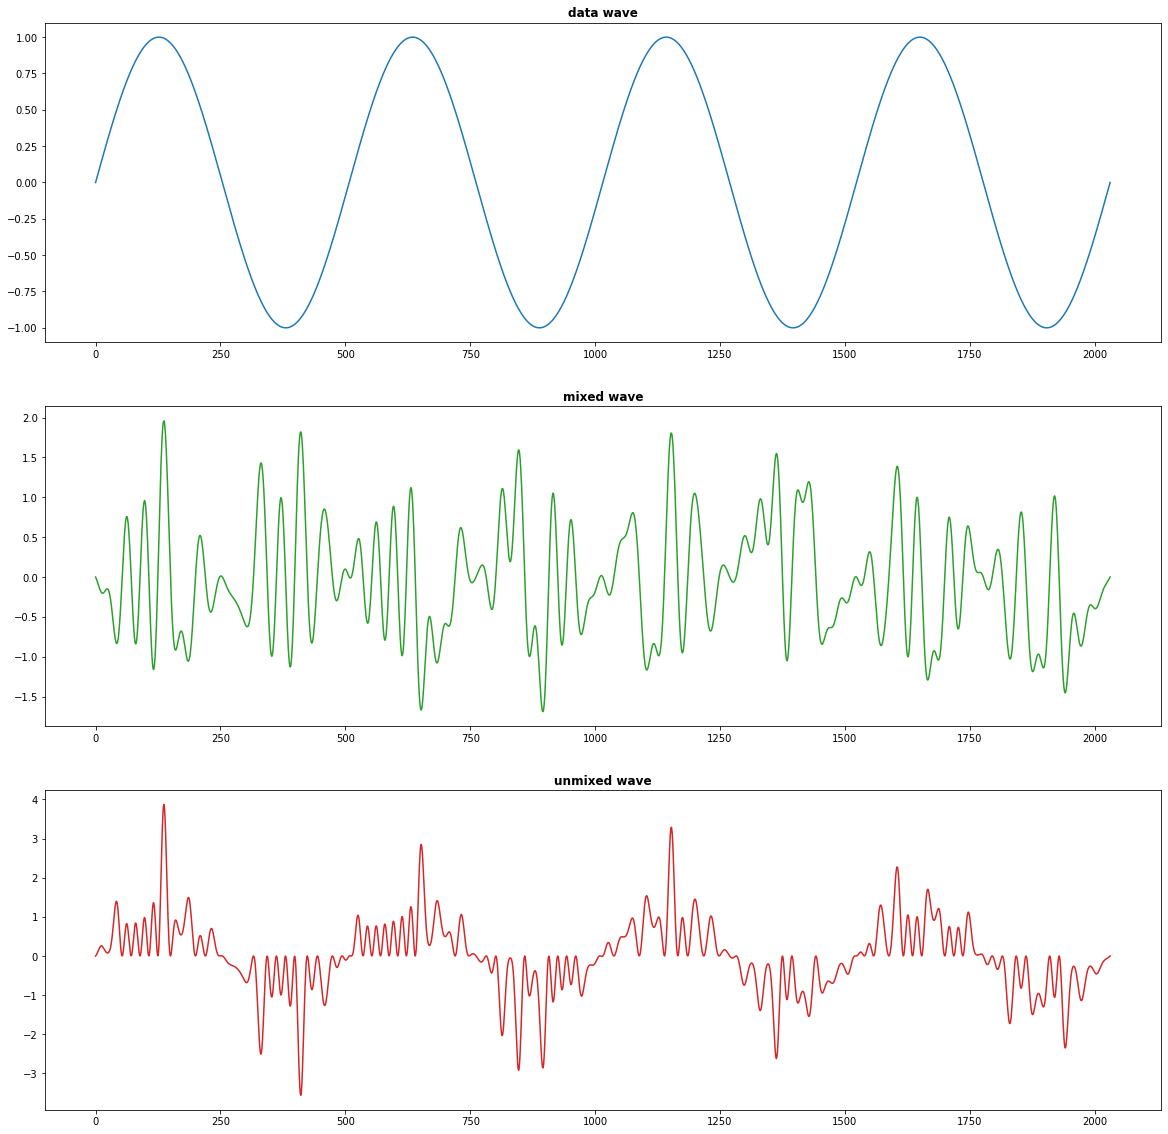

In [36]:
x = np.linspace(0, 42.33, 2032)
y = np.sin(2 * np.pi * ((4+0)/42.33) * x)

print(len(x))
print(len(y))

z = np.multiply(y, us1)

mot = np.multiply(z, us1)

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(20,20))
# fig.suptitle('Vertically stacked subplots')
ax1.plot(y)
ax1.set_title('Data Wave', fontsize=12, fontweight="bold")
ax2.plot(z, 'tab:green')
ax2.set_title('Mixed Wave', fontsize=12, fontweight="bold")
ax3.plot(mot, 'tab:red')
ax3.set_title('Unmixed Wave', fontsize=12, fontweight="bold")

## Contd
<ul>
<li> Now lets take an FFT of the mixed and unmixed waves to see what we get
<li> You can clearly see 2 distinct spikes in the Unmixed FFT. That's the original tone that was mixed in with the code-signal.
<li> And a a completely different FFT plot for the Mixed FFT. Here the bandwidth usage (amount of spectrum in use) is much more than the one above.

Text(0.5, 1.0, 'Fourier transform of Spread/Mixed wave')

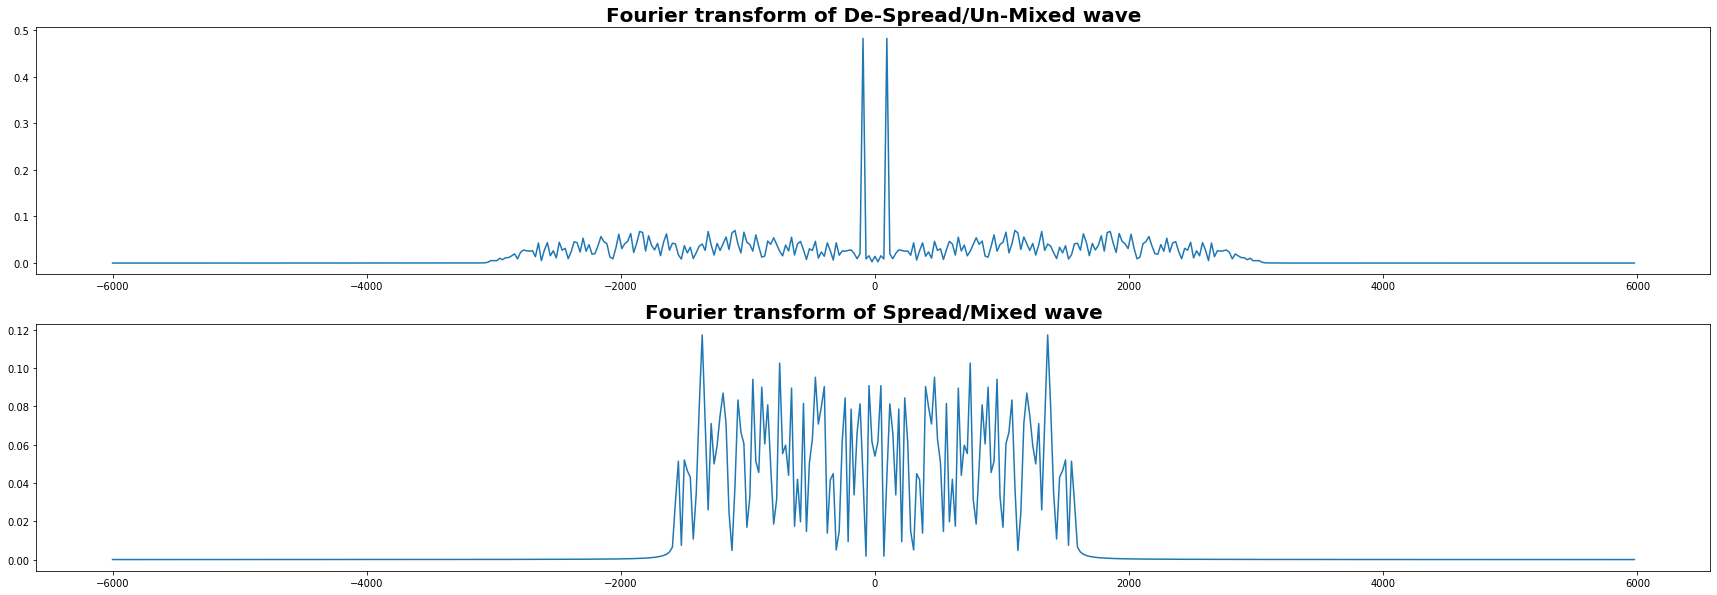

In [38]:
f = signal.resample(mot, 512)

N = 512
# sample spacing
T = 1.0 / 12000.0
yf = fft(f)
xf = fftfreq(N, T)
xf = fftshift(xf)
yplot = fftshift(yf)

f1 = signal.resample(z, 512)

N = 512
# sample spacing
T = 1.0 / 12000.0
yf1 = fft(f1)
xf1 = fftfreq(N, T)
xf1 = fftshift(xf1)
yplot1 = fftshift(yf1)

fig, (ax1, ax2) = plt.subplots(2, figsize=(30,10))
# fig.suptitle('Vertically stacked subplots')
ax1.plot(xf, 1.0/N * np.abs(yplot))
ax1.set_title('Fourier transform of De-Spread/Un-Mixed wave', fontsize=20, fontweight="bold")
ax2.plot(xf1, 1.0/N * np.abs(yplot1))
ax2.set_title('Fourier transform of Spread/Mixed wave', fontsize=20, fontweight="bold")